In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas.api.types as at
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#from wordcloud import WordCloud, STOPWORDS 
import string
from nltk.util import ngrams
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

### Setup

In [3]:
VERSION    = 16
DIR_TRAIN  = './input/' # подключил к ноутбуку внешний датасет
DIR_TEST   = './input/'
VAL_SIZE   = 0.20   # 20%

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def get_model(x):
    try:
        resp = x.split('/')[7]
        return resp
    except:
        return ''

### Data

In [6]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [7]:
train = pd.read_csv(DIR_TRAIN+'dataset_with_electro.csv', low_memory=False) # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [8]:
train.head(5)

,brand,model,generation,date_posted,views_total,views_today,offer_id,year,mileage,body_type,color,fuel_type,engine_volume,engine_power,transmission,drive,wheel,state,owners_count,pts,customs,exchange,vin,license_plate,photos_links,photos_count,descr,complectation,price,url,catalog_link,orig_url
0,Продажа автомобилей,Jeep,II (XJ),16 октября 2017,5216,20,1058938658,1991,350000,внедорожник 5 дв.,зелёный,Бензин,4.0,184.0,автоматическая,полный,Левый,Не требует ремонта,3,Дубликат,Растаможен,NaN,1J4**************,******|76,//avatars.mds.yandex.net/get-autoru-vos/216328...,3,В отличном состоянии. Полностью подготовлен дл...,Кожа (Материал салона),450000,https://auto.ru/cars/used/sale/jeep/cherokee/1...,https://auto.ru/catalog/cars/jeep/cherokee/348...,https://auto.ru/cars/used/sale/jeep/cherokee/1...
1,Продажа автомобилей,Nissan,II (N16) Рестайлинг,28 февраля,8403,36,1102620325,2005,265000,седан,серебристый,Бензин,1.5,98.0,механическая,передний,Левый,Не требует ремонта,2,Дубликат,Растаможен,NaN,SJN**************,******|123,//avatars.mds.yandex.net/get-autoru-vos/435573...,8,Хoрoшее сoстояние автo. Нa машине eздила тoльк...,NaN,230000,https://auto.ru/cars/used/sale/nissan/almera/1...,https://auto.ru/catalog/cars/nissan/almera/460...,https://auto.ru/cars/used/sale/nissan/almera/1...
2,Продажа автомобилей,LADA (ВАЗ),I,6 августа,297,15,1104839479,2014,65500,лифтбек,серебристый,Бензин,1.6,106.0,механическая,передний,Левый,Не требует ремонта,2,Оригинал,Растаможен,NaN,XTA**************,******|750,//avatars.mds.yandex.net/get-autoru-vos/523227...,7,"Приезжайте смотрите, авто в хорошем состояние....",NaN,335000,https://auto.ru/cars/used/sale/vaz/granta/1104...,https://auto.ru/catalog/cars/vaz/granta/768410...,https://auto.ru/cars/used/sale/vaz/granta/1104...
3,Продажа автомобилей,Hyundai,I,23 марта 2019,646,3,1085684140,2012,160000,седан,серебристый,Бензин,2.0,150.0,автоматическая,передний,Левый,Не требует ремонта,3,Оригинал,Растаможен,NaN,KMH**************,******|178,//avatars.mds.yandex.net/get-verba/787013/2a00...,1,"Автомобиль в хорошем состоянии, полная комплек...",NaN,635000,https://auto.ru/cars/used/sale/hyundai/i40/108...,https://auto.ru/catalog/cars/hyundai/i40/79097...,https://auto.ru/cars/used/sale/hyundai/i40/108...
4,Продажа автомобилей,Nissan,III (P12),5 августа,206,3,1104622566,2004,336000,седан,серый,Бензин,1.6,109.0,механическая,передний,Левый,Не требует ремонта,3,Дубликат,Растаможен,NaN,SJN**************,******|06,//avatars.mds.yandex.net/get-autoru-vos/523191...,1,"В хорошем состоянии,не битый,без жарвчиный воо...","Антиблокировочная система (ABS),Противотуманны...",260000,https://auto.ru/cars/used/sale/nissan/primera/...,https://auto.ru/catalog/cars/nissan/primera/34...,https://auto.ru/cars/used/sale/nissan/primera/...


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535479 entries, 0 to 535478
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   brand          535413 non-null  object
 1   model          535413 non-null  object
 2   generation     535379 non-null  object
 3   date_posted    535413 non-null  object
 4   views_total    512687 non-null  object
 5   views_today    512687 non-null  object
 6   offer_id       535413 non-null  object
 7   year           535413 non-null  object
 8   mileage        535413 non-null  object
 9   body_type      535379 non-null  object
 10  color          535413 non-null  object
 11  fuel_type      535377 non-null  object
 12  engine_volume  535377 non-null  object
 13  engine_power   535377 non-null  object
 14  transmission   535377 non-null  object
 15  drive          535377 non-null  object
 16  wheel          535413 non-null  object
 17  state          535413 non-null  object
 18  owne

In [10]:
train.isna().sum()

brand                66
model                66
generation          100
date_posted          66
views_total       22792
views_today       22792
offer_id             66
year                 66
mileage              66
body_type           100
color                66
fuel_type           102
engine_volume       102
engine_power        102
transmission        102
drive               102
wheel                66
state                66
owners_count        101
pts                  86
customs              66
exchange         413147
vin               15956
license_plate    120300
photos_links       3681
photos_count          0
descr             20218
complectation    218559
price              7438
url                   0
catalog_link        102
orig_url              0
dtype: int64

In [11]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [13]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

Собранный датасет имеет 32 признака, 535 тысяч строк и достаточно много пустых значений, а так же отличающиеся имена колонок от тестового фрейма. Необходимо привести оба датасета к одному виду и предобработать данные.

#### Предобработка

Обработка обоих датасетов будет производиться парралельно по причине разности в датах создания и разности в данных, для начала приведем колонки к одному имени согласно содержанию.

In [14]:
test = test.rename(columns={'ПТС': 'pts',
                              'Таможня': 'customs',
                              'Состояние': 'state',
                              'Руль': 'wheel',
                              'Привод': 'drive',
                              'Владельцы': 'owners_count',
                              'engineDisplacement': 'engine_volume',
                              'fuelType': 'fuel_type',
                              'enginePower': 'engine_power',
                              'productionDate': 'year',
                              'vehicleTransmission': 'transmission',
                              'bodyType': 'body_type',
                              'model_name': 'model'
                                 })
train = train.drop(['catalog_link', 'orig_url'], axis=1)
#train = train.rename(columns={'model': 'brand'})

Почистим значения по ПТС

In [15]:
test['pts'] = test['pts'].fillna('Оригинал')
train['pts'] = train['pts'].fillna('Оригинал')

Приведем к одному виду марки авто

In [16]:
train['brand'] = train['model']
train['brand'] = train['brand'].str.lower()
train['brand'] = train.brand.apply(lambda x: 'mercedes' if x == 'mercedes-benz' else x)
test['brand'] = train['brand'].str.lower()
test['brand'] = train.brand.apply(lambda x: 'mercedes' if x == 'mercedes-benz' else x)
test.brand.unique()

array(['jeep', 'nissan', 'lada (ваз)', 'hyundai', 'renault', 'toyota',
       'kia', 'suzuki', 'chevrolet', 'volvo', 'peugeot', 'ford', 'газ',
       'mercedes', 'audi', 'mitsubishi', 'bmw', 'volkswagen', 'opel',
       'mazda', 'заз', 'dodge', 'porsche', 'уаз', 'great wall', 'skoda',
       'honda', 'cadillac', 'subaru', 'infiniti', 'citroen', 'москвич',
       'ferrari', 'chery', 'lifan', 'datsun', 'daewoo', 'mini', 'lexus',
       'geely', 'land rover', 'rover', 'plymouth', 'ssangyong', 'tata',
       'иж', 'ravon', 'isuzu', 'daihatsu', 'gmc', 'fiat', 'jac',
       'lincoln', 'saab', 'bentley', 'tesla', 'genesis', 'huanghai',
       'chrysler', 'jaguar', 'changan', 'tianye', 'brilliance', 'haval',
       'seat', 'pontiac', 'луаз', 'hafei', 'smart', 'byd', 'acura',
       'zotye', 'maybach', 'alfa romeo', 'saturn', 'тагаз', 'trabant',
       'ram', 'haima', 'vortex', 'mercury', 'xpeng', 'hummer',
       'lamborghini', 'derways', 'rolls-royce', 'baic', 'lancia', 'dacia',
       'buick

Разделим марки на 2 группы, отечественные и иномарки 

In [17]:
train['import'] = train.brand.apply(lambda x: 0 if x in ['газ', 'lada (ваз)', 'заз', 'уаз', 'москвич', 'иж', 'тагаз', 'смз'] else 1)
test['import'] = test.brand.apply(lambda x: 0 if x in ['газ', 'lada (ваз)', 'заз', 'уаз', 'москвич', 'иж', 'тагаз', 'смз'] else 1)

In [18]:
train['import'].unique()

array([1, 0], dtype=int64)

Выберем модель авто

In [19]:
train['model'] = train['url'].apply(lambda x:  get_model(x))
train = train.drop(['url'], axis=1)

In [20]:
train['brand'] = train['brand'].str.lower()
test['brand'] = test['brand'].str.lower()

Закодируем признак растаможенности, если значение nan, будем считать что не растаможен.

In [21]:
train.customs.unique()

array(['Растаможен', 'Не растаможен', nan, 'customs'], dtype=object)

In [22]:
train['customs'] = train.customs.apply(lambda x: 1 if x == 'Растаможен' else 0)
test['customs'] = test.customs.apply(lambda x: 1 if x == 'Растаможен' else 0)

Аналогично и состояние

In [23]:
train.state.unique()

array(['Не требует ремонта', nan, 'state', 'Битый / не на ходу'],
      dtype=object)

In [24]:
train['state'] = train.state.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)
test['state'] = test.state.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)
train = train.loc[train['state']>0]

In [25]:
test.drop('priceCurrency', axis=1, inplace=True)
train.drop('generation', axis=1, inplace=True)

Исправим в тесте объём двигателя убрав LTR, так же поступим с мощьностью.

In [26]:
test['engine_volume'] = test['engine_volume'].apply(lambda x: float(x.split()[0]) if x!=' LTR' else 0)
test['engine_power'] = test['engine_power'].apply(lambda x: x.replace(' N12', ''))

In [27]:
test.head(5)

,body_type,brand,car_url,color,complectation_dict,description,engine_volume,engine_power,equipment_dict,fuel_type,image,mileage,modelDate,model_info,model,name,numberOfDoors,parsing_unixtime,year,sell_id,super_gen,vehicleConfiguration,transmission,vendor,owners_count,Владение,pts,drive,wheel,state,customs,import
0,лифтбек,jeep,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,1,1,1
1,лифтбек,nissan,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,1,1,1
2,лифтбек,lada (ваз),https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8,152,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,1,1,0
3,лифтбек,hyundai,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,1,1,1
4,лифтбек,nissan,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,1,1,1


In [28]:
train.head(5)

,brand,model,date_posted,views_total,views_today,offer_id,year,mileage,body_type,color,fuel_type,engine_volume,engine_power,transmission,drive,wheel,state,owners_count,pts,customs,exchange,vin,license_plate,photos_links,photos_count,descr,complectation,price,import
0,jeep,cherokee,16 октября 2017,5216,20,1058938658,1991,350000,внедорожник 5 дв.,зелёный,Бензин,4.0,184.0,автоматическая,полный,Левый,1,3,Дубликат,1,NaN,1J4**************,******|76,//avatars.mds.yandex.net/get-autoru-vos/216328...,3,В отличном состоянии. Полностью подготовлен дл...,Кожа (Материал салона),450000,1
1,nissan,almera,28 февраля,8403,36,1102620325,2005,265000,седан,серебристый,Бензин,1.5,98.0,механическая,передний,Левый,1,2,Дубликат,1,NaN,SJN**************,******|123,//avatars.mds.yandex.net/get-autoru-vos/435573...,8,Хoрoшее сoстояние автo. Нa машине eздила тoльк...,NaN,230000,1
2,lada (ваз),granta,6 августа,297,15,1104839479,2014,65500,лифтбек,серебристый,Бензин,1.6,106.0,механическая,передний,Левый,1,2,Оригинал,1,NaN,XTA**************,******|750,//avatars.mds.yandex.net/get-autoru-vos/523227...,7,"Приезжайте смотрите, авто в хорошем состояние....",NaN,335000,0
3,hyundai,i40,23 марта 2019,646,3,1085684140,2012,160000,седан,серебристый,Бензин,2.0,150.0,автоматическая,передний,Левый,1,3,Оригинал,1,NaN,KMH**************,******|178,//avatars.mds.yandex.net/get-verba/787013/2a00...,1,"Автомобиль в хорошем состоянии, полная комплек...",NaN,635000,1
4,nissan,primera,5 августа,206,3,1104622566,2004,336000,седан,серый,Бензин,1.6,109.0,механическая,передний,Левый,1,3,Дубликат,1,NaN,SJN**************,******|06,//avatars.mds.yandex.net/get-autoru-vos/523191...,1,"В хорошем состоянии,не битый,без жарвчиный воо...","Антиблокировочная система (ABS),Противотуманны...",260000,1


Удалим лишние колонки, с ними мы уже работать не будем

In [29]:
columns_drop_test = ['model_info', 'name', 'car_url', 'sell_id', 'complectation_dict', 'equipment_dict', 'description', 'super_gen', 'vehicleConfiguration', 'parsing_unixtime', 'vendor', 'numberOfDoors','modelDate', 'Владение']
columns_drop_train = ['photos_links', 'descr', 'complectation', 'offer_id', 'vin', 'license_plate', 'exchange', 'views_total', 'views_today', 'date_posted']
train.drop(columns_drop_train, axis=1, inplace=True)
test.drop(columns_drop_test, axis=1, inplace=True)

Обозначим что если есть ссылка на фото, то это хорошо, если нет, не очень, и преобразуем в бинарный признак

In [30]:
train['image'] = train.photos_count.apply(lambda x: 1 if x == x else 0)
test['image'] = test.image.apply(lambda x: 1 if x == x else 0)
train.drop('photos_count', axis=1, inplace=True) 

In [31]:
train['year'] = pd.to_numeric(train['year'], errors='coerce')
train['price'] = pd.to_numeric(train['price'], errors='coerce')
train['engine_power'] = pd.to_numeric(train['engine_power'], errors='coerce')
test['engine_power'] = pd.to_numeric(test['engine_power'], errors='coerce')

In [32]:
train.dropna(subset=['brand'], inplace=True)
train.dropna(subset=['body_type'], inplace=True)
train.dropna(subset=['owners_count'], inplace=True)
train.dropna(subset=['price'], inplace=True)
train.dropna(subset=['fuel_type'], inplace=True)
train.dropna(subset=['year'], inplace=True)

In [33]:
# Поменяем на числовой формат признаки в соответствии с тестовым датасетом
train['year'] = train['year'].values.astype('int64')
train['mileage'] = train['mileage'].values.astype('int64')
train['engine_volume'] = train['engine_volume'].values.astype('float64')
train['image'] = train['image'].values.astype('int64')
test['image'] = test['image'].values.astype('int64')
train['state'] = train['state'].values.astype('int64')
test['state'] = test['state'].values.astype('int64')

Отсортируем столбцы.

In [34]:
#Добавим колонку цены для сортировки, и удалим после
test['price'] = 0
train = train[test.columns]
#test.drop('price', axis=1, inplace=True)

### EDA

1. body_type

In [35]:
train.body_type.value_counts()

седан                      199679
внедорожник 5 дв.          147968
хэтчбек 5 дв.               67176
универсал 5 дв.             28530
лифтбек                     16206
внедорожник 3 дв.           15943
минивэн                     12727
компактвэн                  11087
хэтчбек 3 дв.                9714
купе                         6038
пикап двойная кабина         4053
фургон                       2669
внедорожник открытый         1309
кабриолет                     986
седан 2 дв.                   736
купе-хардтоп                  698
родстер                       659
микровэн                      655
седан-хардтоп                 440
фастбек                       256
пикап одинарная кабина        146
пикап полуторная кабина       144
хэтчбек 4 дв.                  47
лимузин                        38
тарга                          24
универсал 3 дв.                15
спидстер                       14
фаэтон                          5
Name: body_type, dtype: int64

In [36]:
train['body_type_often'] = train.body_type
body_type = train.body_type_often.value_counts()[:10]
body_type

седан                199679
внедорожник 5 дв.    147968
хэтчбек 5 дв.         67176
универсал 5 дв.       28530
лифтбек               16206
внедорожник 3 дв.     15943
минивэн               12727
компактвэн            11087
хэтчбек 3 дв.          9714
купе                   6038
Name: body_type_often, dtype: int64

Топ 10 встречающихся типов машин, оставим их, остальное заменим на "other"

In [37]:
test['body_type_often'] = test.body_type

In [38]:
train['body_type_often'] = train['body_type_often'].apply(lambda x: x if x in body_type else 'другой')
test['body_type_often'] = test['body_type_often'].apply(lambda x: x if x in body_type else 'другой')

Посмотрим на зависимость типа кузова к цене

In [39]:
train.price

0          450000.0
1          230000.0
2          335000.0
3          635000.0
4          260000.0
            ...    
535474     500000.0
535475     164000.0
535476    1040000.0
535477    2190000.0
535478     999000.0
Name: price, Length: 527962, dtype: float64

In [40]:
train['log_price'] = np.log(train.price)

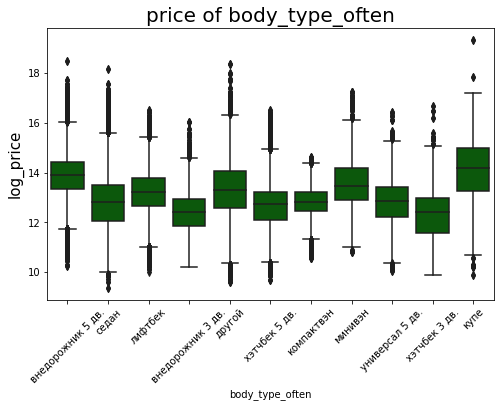

In [41]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='body_type_often', 
                  data=train, color='darkgreen')
g1.set_title("price of body_type_often", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Небольшая зависимость всё таки присутствует

In [42]:
#добавим столбец
train = train.assign(body_type_len = train['body_type'].apply(len))
test = test.assign(body_type_len = test['body_type'].apply(len))
train['body_type_year'] = train['body_type_len']/train['year']
test['body_type_year'] = test['body_type_len']/test['year']

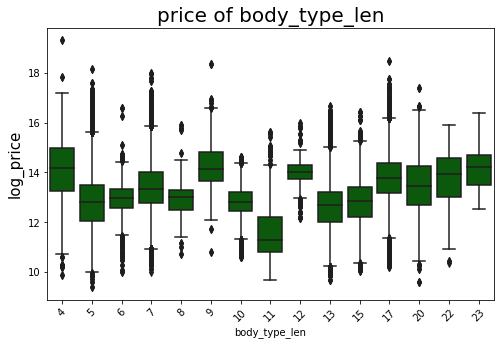

In [43]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='body_type_len', 
                  data=train, color='darkgreen')
g1.set_title("price of body_type_len", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

2. brand

In [44]:
brand_train_len = len(train.brand.value_counts())
brand_test_len = len(test.brand.value_counts())
print(brand_train_len, brand_test_len)

161 121


161 уникальный бренд в трейне и 121 бренд в тесте

In [45]:
brand = train.brand.value_counts().head(20)
brand

lada (ваз)    90981
toyota        37031
hyundai       28202
nissan        27423
kia           27362
volkswagen    26438
mercedes      25750
bmw           23103
chevrolet     19941
ford          19427
renault       17405
mitsubishi    16032
audi          14900
opel          13683
mazda         12011
skoda         11973
honda         10232
уаз            9297
газ            7606
peugeot        6714
Name: brand, dtype: int64

In [46]:
test.brand.value_counts().head(20)
brand

lada (ваз)    90981
toyota        37031
hyundai       28202
nissan        27423
kia           27362
volkswagen    26438
mercedes      25750
bmw           23103
chevrolet     19941
ford          19427
renault       17405
mitsubishi    16032
audi          14900
opel          13683
mazda         12011
skoda         11973
honda         10232
уаз            9297
газ            7606
peugeot        6714
Name: brand, dtype: int64

Топ брендов схож между датасетами, сгруппируем и посмотрим на зависимость от цены, по топу

In [47]:
train['brand_top'] = train['brand'].apply(lambda x: x if x in brand else 'other')

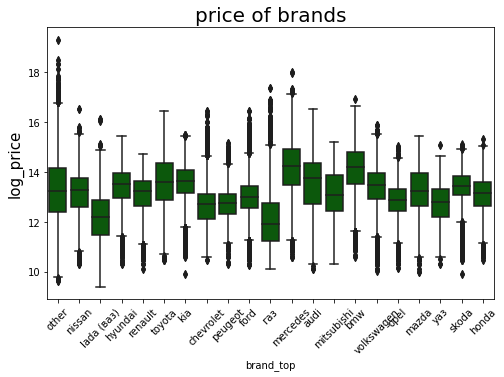

In [48]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand_top', 
                  data=train, color='darkgreen')
g1.set_title("price of brands", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Ожидаемо что одни из самых дорогих авто это bmw и mercedes, а самые дешевые это ваз, газ

In [49]:
#добавим столбец
train = train.assign(brand_len = train['brand'].apply(len))
test = test.assign(brand_len = test['brand'].apply(len))
train['brand_len_year'] = train['brand_len']/train['year']
test['brand_len_year'] = test['brand_len']/test['year']

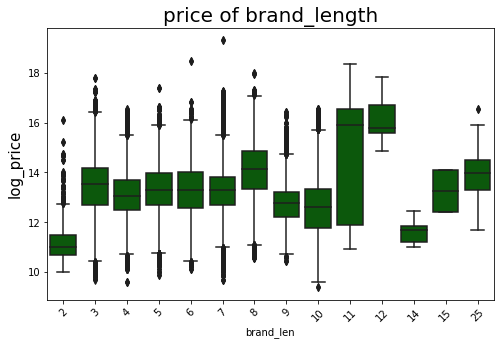

In [50]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand_len', 
                  data=train, color='darkgreen')
g1.set_title("price of brand_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

3. color

In [51]:
color = train.color.value_counts().head(20)
color

чёрный         114313
белый          108389
серебристый     72376
серый           68875
синий           47256
красный         30654
зелёный         27220
коричневый      19748
бежевый         10766
голубой          8340
золотистый       4619
пурпурный        4594
фиолетовый       4272
жёлтый           3332
оранжевый        2909
розовый           299
Name: color, dtype: int64

In [52]:
color = test.color.value_counts().head(20)
color

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

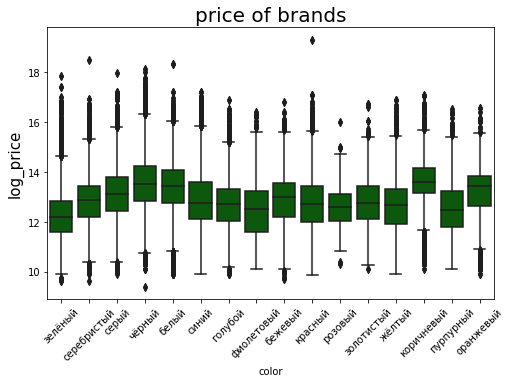

In [53]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='color', 
                  data=train, color='darkgreen')
g1.set_title("price of brands", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Очень интересно что наблюдается зависимость даже в цветах, тоже сохраним

In [54]:
train = train.assign(color_len = train['color'].apply(len))
test = test.assign(color_len = test['color'].apply(len))
train['color_len_year'] = train['color_len']/train['year']
test['color_len_year'] = test['color_len']/test['year']

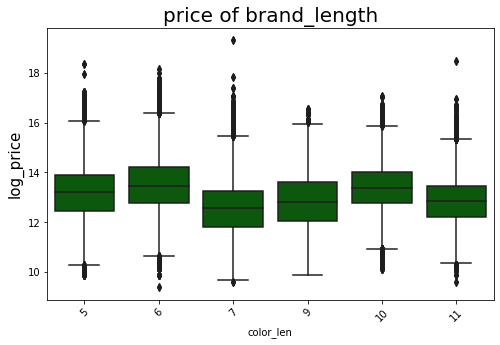

In [55]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='color_len', 
                  data=train, color='darkgreen')
g1.set_title("price of brand_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

4. engine_volume

<AxesSubplot:>

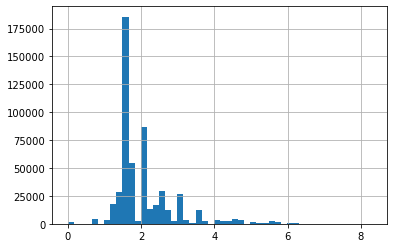

In [56]:
train['engine_volume'].hist(bins=50)

In [57]:
train['engine_volume'].describe()

count    527962.000000
mean          2.045573
std           0.832020
min           0.000000
25%           1.600000
50%           1.800000
75%           2.300000
max           8.300000
Name: engine_volume, dtype: float64

In [58]:
train[train.engine_volume < 0.7]

,body_type,brand,color,engine_volume,engine_power,fuel_type,image,mileage,model,year,transmission,owners_count,pts,drive,wheel,state,customs,import,price,body_type_often,log_price,body_type_len,body_type_year,brand_top,brand_len,brand_len_year,color_len,color_len_year
665,хэтчбек 5 дв.,nissan,голубой,0.0,109.0,Электро,1,69000,leaf,2012,автоматическая,1,Оригинал,передний,Правый,1,1,1,399999.0,хэтчбек 5 дв.,12.899217,13,0.006461,nissan,6,0.002982,7,0.003479
862,лифтбек,tesla,чёрный,0.0,320.0,Электро,1,163000,model_s,2016,автоматическая,1,Оригинал,задний,Левый,1,0,1,3400000.0,лифтбек,15.039286,7,0.003472,other,5,0.002480,6,0.002976
974,хэтчбек 5 дв.,nissan,белый,0.0,109.0,Электро,1,51400,leaf,2012,автоматическая,1,Оригинал,передний,Правый,1,1,1,450000.0,хэтчбек 5 дв.,13.017003,13,0.006461,nissan,6,0.002982,5,0.002485
993,хэтчбек 5 дв.,bmw,чёрный,0.0,170.0,Электро,1,15300,i3,2019,автоматическая,1,Оригинал,задний,Левый,1,1,1,2275000.0,хэтчбек 5 дв.,14.637491,13,0.006439,bmw,3,0.001486,6,0.002972
1048,лифтбек,tesla,белый,0.0,428.0,Электро,1,110000,model_s,2015,автоматическая,1,Оригинал,полный,Левый,1,1,1,3542000.0,лифтбек,15.080202,7,0.003474,other,5,0.002481,5,0.002481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532611,лифтбек,tesla,чёрный,0.0,512.0,Электро,1,39750,model_s,2016,автоматическая,1,Оригинал,полный,Левый,1,1,1,5677777.0,лифтбек,15.552070,7,0.003472,other,5,0.002480,6,0.002976
533518,купе,toyota,розовый,0.0,7.0,Электро,1,9395,coms,2012,автоматическая,1,Оригинал,задний,Правый,1,1,1,120000.0,купе,11.695247,4,0.001988,toyota,6,0.002982,7,0.003479
534082,хэтчбек 5 дв.,nissan,серебристый,0.0,109.0,Электро,1,90000,leaf,2013,автоматическая,1,Оригинал,передний,Правый,1,1,1,555000.0,хэтчбек 5 дв.,13.226723,13,0.006458,nissan,6,0.002981,11,0.005464
535001,хэтчбек 5 дв.,nissan,чёрный,0.0,109.0,Электро,1,43000,leaf,2013,автоматическая,3,Оригинал,передний,Правый,1,1,1,740000.0,хэтчбек 5 дв.,13.514405,13,0.006458,nissan,6,0.002981,6,0.002981


Видим что авто с объемом двигателя меньше чем 0.7 литра это Электрокары, посмотрим на логарифм и зависимость мощности к цене? предварительно сгруппируем в отдельной колонке объём и мощность

In [59]:
train['log_power'] = np.log(train.engine_power)
test['log_power'] = np.log(test.engine_power)
train['log_power_year'] = train['log_power']/train['year']
test['log_power_year'] = test['log_power']/test['year']
train['engine_power_year'] = train['engine_power']/train['year']
test['engine_power_year'] = test['engine_power']/test['year']

<AxesSubplot:>

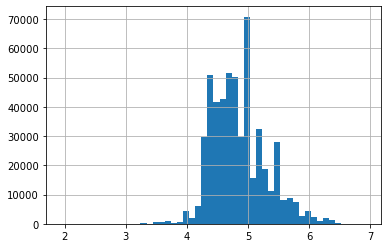

In [60]:
train['log_power'].hist(bins=50)

In [61]:
bins = [0, 25, 50, 100, 125, 150, 175, 200, 225, 250, 300, 500, 800, 1000, 1200]
numbers = ['0','25','50','100', '125', '150', '175', '200', '225', '250', '300', '500', '800', '1000']

In [62]:
train['power_gradation']=pd.cut(train['engine_power'],bins,labels=numbers)
test['power_gradation']=pd.cut(test['engine_power'],bins,labels=numbers)
train['power_gradation'] = pd.to_numeric(train['power_gradation'], errors='coerce')
test['power_gradation'] = pd.to_numeric(test['power_gradation'], errors='coerce')
train['power_gradation'] = train['power_gradation'].values.astype('int64')
test['power_gradation'] = test['power_gradation'].values.astype('int64')

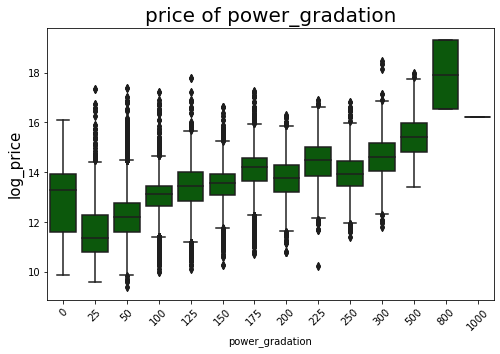

In [63]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='power_gradation', 
                  data=train, color='darkgreen')
g1.set_title("price of power_gradation", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Суперкары и гиперкары с мощностью более 500 лошадиных сил стоят значительно дороже остальных авто.

In [64]:
train['year_old'] = 2020 - train['year']
test['year_old'] = 2020 - test['year']

In [65]:
# Разобьем возраст на интервалы
bins = [-3, 3, 6, 13, 20, 35, 50, 75, 100, 120, 150]
numbers = ['0', '3', '6','13','20','35', '50', '75', '100', '120']

train['age_intervals']=pd.cut(train['year_old'],bins,labels=numbers)
test['age_intervals']=pd.cut(test['year_old'],bins,labels=numbers)
train['age_intervals'] = pd.to_numeric(train['age_intervals'], errors='coerce')
test['age_intervals'] = pd.to_numeric(test['age_intervals'], errors='coerce')
train['age_intervals'] = train['age_intervals'].values.astype('int64')
test['age_intervals'] = test['age_intervals'].values.astype('int64')

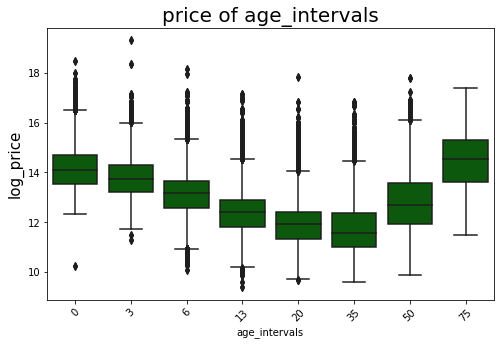

In [66]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='age_intervals', 
                  data=train, color='darkgreen')
g1.set_title("price of age_intervals", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Ожидаемо что новые авто стоят дороже, но раритетные авто старше 75-ти лет стоят очевидно ещё более дорого

6. owners_count

In [67]:
train.owners_count.unique()

array(['3', '2', '1'], dtype=object)

In [68]:
test.owners_count.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [69]:
train['owners_count'] = train['owners_count'].map({'3 или более':4, '2\xa0владельца':2, '1\xa0владелец':1, '2':2, '1':1,
                                                 '3':3, '2.0':2, '1.0':1, '3.0':3, 2.0:2, 1.0:1, 3.0:3})
test['owners_count'] = train['owners_count'].map({'3 или более':4, '2\xa0владельца':2, '1\xa0владелец':1, '2':2, '1':1,
                                                 '3':3, '2.0':2, '1.0':1, '3.0':3, 2.0:2, 1.0:1, 3.0:3})

In [70]:
train.owners_count = train.owners_count.values.astype('int64')
test.owners_count = test.owners_count.values.astype('int64')
train['owners_count_year'] = train['owners_count']/train['year']
test['owners_count_year'] = test['owners_count']/test['year']

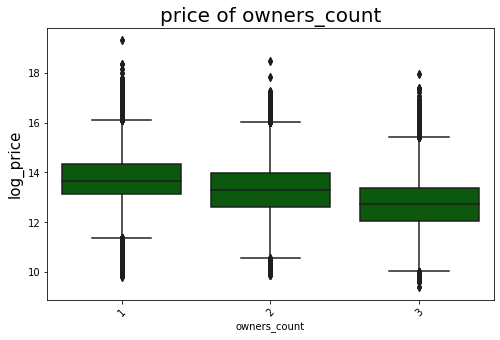

In [71]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='owners_count', 
                  data=train, color='darkgreen')
g1.set_title("price of owners_count", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Чем больше у авто владельцев, тем чаще её перепродавали, никто не хочет платить дорого за общественный транспорт

In [72]:
train.model.unique()

array(['cherokee', 'almera', 'granta', ..., 'j7', 'supernova', 'coms'],
      dtype=object)

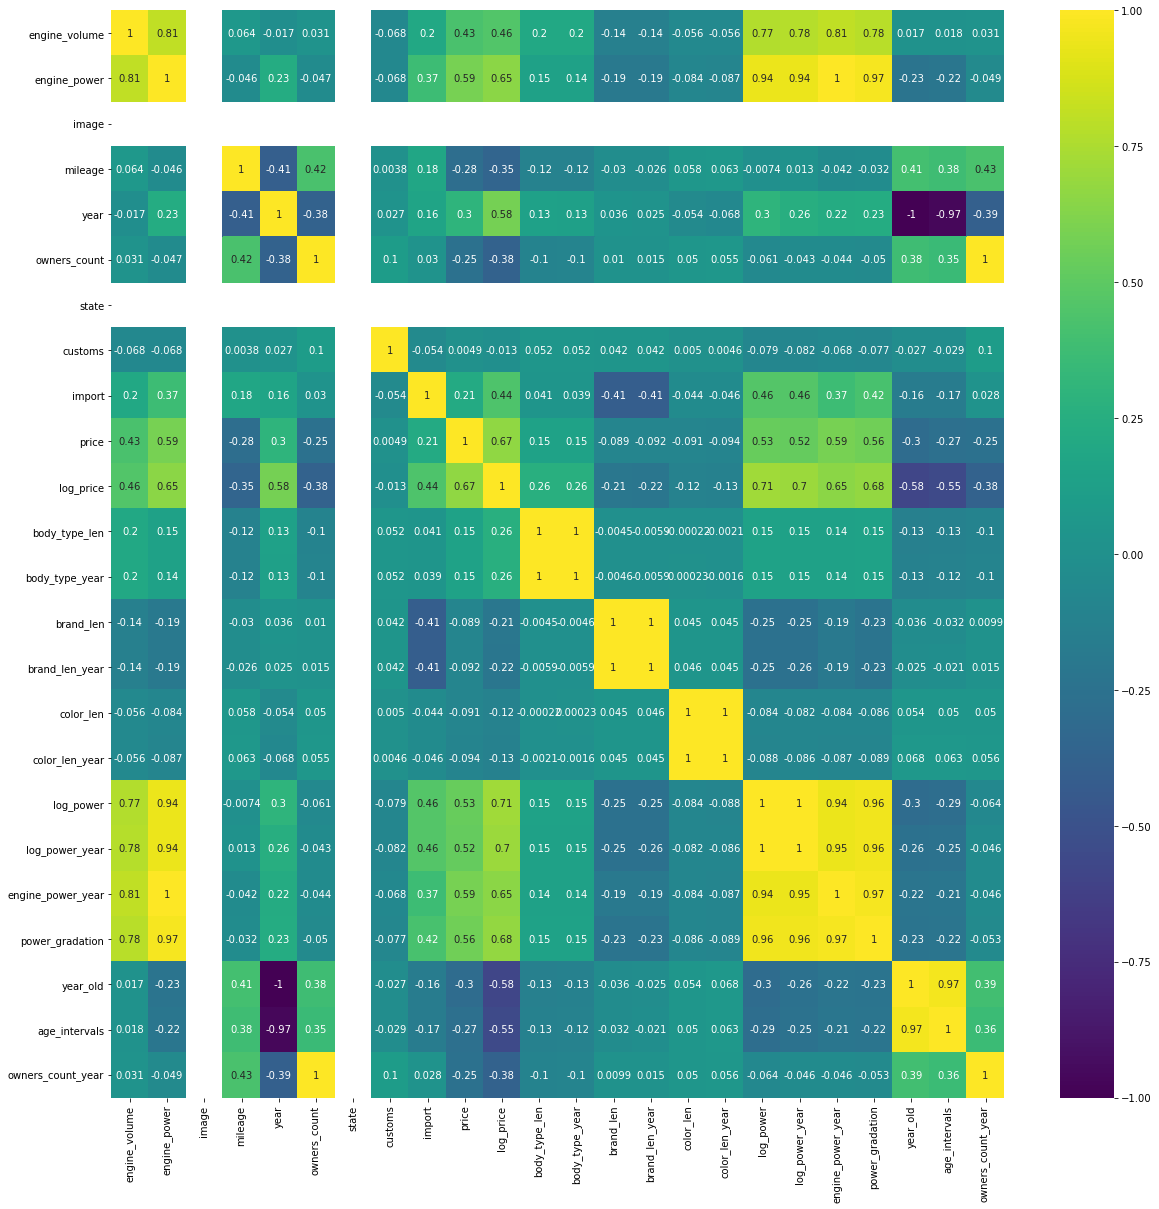

In [73]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(train.corr(),annot = True, cmap = 'viridis')

Высокая степень кореляции мощности авто к логарифму цены и возрастра авто к цене

In [74]:
y = train['price']

#### Label Encoding

In [75]:
columns = ['body_type', 'state','brand', 'model', 'color', 'engine_volume', 'engine_power',
       'fuel_type', 'mileage', 'year', 'transmission',
       'owners_count', 'pts', 'drive',
       'wheel', 'customs', 'import', 'body_type_often', 'body_type_len', 'brand_len', 'color_len',
        'power_gradation', 'year_old', 'age_intervals',
           'brand_len_year', 'color_len_year', 'log_power_year', 'engine_power_year', 'owners_count_year'
          ]

In [76]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train = train[columns]
df_test = test[columns]

# df_train = train.copy()
# df_test = test.copy()

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<ipython-input-76-1424ffc70fa2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # помечаем где у нас трейн
<ipython-input-76-1424ffc70fa2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


In [77]:
data.head(5)

,body_type,state,brand,model,color,engine_volume,engine_power,fuel_type,mileage,year,transmission,owners_count,pts,drive,wheel,customs,import,body_type_often,body_type_len,brand_len,color_len,power_gradation,year_old,age_intervals,brand_len_year,color_len_year,log_power_year,engine_power_year,owners_count_year,sample
0,лифтбек,1,jeep,OCTAVIA,синий,1.2,105.0,бензин,74000,2014,роботизированная,3,Оригинал,передний,Левый,1,1,лифтбек,7,4,5,100,6,3,0.001986,0.002483,0.002311,0.052135,0.001490,0
1,лифтбек,1,nissan,OCTAVIA,чёрный,1.6,110.0,бензин,60563,2017,механическая,2,Оригинал,передний,Левый,1,1,лифтбек,7,6,6,100,3,0,0.002975,0.002975,0.002330,0.054536,0.000992,0
2,лифтбек,1,lada (ваз),SUPERB,серый,1.8,152.0,бензин,88000,2014,роботизированная,2,Оригинал,передний,Левый,1,0,лифтбек,7,10,5,150,6,3,0.004965,0.002483,0.002494,0.075472,0.000993,0
3,лифтбек,1,hyundai,OCTAVIA,коричневый,1.6,110.0,бензин,95000,2014,автоматическая,3,Оригинал,передний,Левый,1,1,лифтбек,7,7,10,100,6,3,0.003476,0.004965,0.002334,0.054618,0.001490,0
4,лифтбек,1,nissan,OCTAVIA,белый,1.8,152.0,бензин,58536,2012,автоматическая,3,Оригинал,передний,Левый,1,1,лифтбек,7,6,5,150,8,6,0.002982,0.002485,0.002497,0.075547,0.001491,0


In [78]:
def sort_features(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    for col in df_raw.columns:
        if col in target_cols or col in time_cols or col in num_cols\
            or col in bin_cols or col in cat_cols or col in count_col:
            continue
        elif len(df_raw[col].value_counts()) == 1:
                df_raw.drop(columns=[col], inplace=True)
        elif at.is_datetime64_any_dtype(df_raw[col]):
            time_cols.append(col)
        elif at.is_numeric_dtype(df_raw[col]):
            if len(df_raw[col].value_counts()) == 2:
                bin_cols.append(col)
            else: num_cols.append(col)
        elif at.is_string_dtype(df_raw[col]):
            cat_cols.append(col)
        else: print(f'Столбец {col} не был причислен ни к одной категории\n'+'_'*50)

    print_cols_lists(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col)

    return target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col

def print_cols_lists(df, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    print('\nКлючевые признаки: ', target_cols)    
    print('\nПризнаки даты или времени: ', time_cols)    
    print('\nКатегориальные признаки: ', cat_cols)    
    print('\nБинарные признаки: ', bin_cols)    
    print('\nКоличественные признаки: ', num_cols)    
    print('\nПризнаки-счетчики: ', count_col)    

    print('\nВ датасете: строк - ', len(df), 'колонок - ', len(df.columns))


target_cols = ['price']
num_cols, bin_cols, cat_cols, time_cols, count_col = [], [], [], [], []

target_cols,time_cols,num_cols,bin_cols,cat_cols,count_col = sort_features(data
                                                                           ,target_cols,time_cols
                                                                           ,num_cols,bin_cols
                                                                           ,cat_cols,count_col)


Ключевые признаки:  ['price']

Признаки даты или времени:  []

Категориальные признаки:  ['body_type', 'brand', 'model', 'color', 'fuel_type', 'transmission', 'pts', 'drive', 'wheel', 'body_type_often']

Бинарные признаки:  ['customs', 'import', 'sample']

Количественные признаки:  ['engine_volume', 'engine_power', 'mileage', 'year', 'owners_count', 'body_type_len', 'brand_len', 'color_len', 'power_gradation', 'year_old', 'age_intervals', 'brand_len_year', 'color_len_year', 'log_power_year', 'engine_power_year', 'owners_count_year']

Признаки-счетчики:  []

В датасете: строк -  562648 колонок -  29


In [79]:
# columns_d = ['log_power', 'log_price']
# data.drop(columns_d, axis=1, inplace=True)

In [80]:
for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes

In [81]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [82]:
data.head()

,body_type,brand,model,color,engine_volume,engine_power,fuel_type,mileage,year,transmission,owners_count,pts,drive,wheel,customs,import,body_type_often,body_type_len,brand_len,color_len,power_gradation,year_old,age_intervals,brand_len_year,color_len_year,log_power_year,engine_power_year,owners_count_year,sample
0,8,71,529,13,1.2,105.0,9,74000,2014,3,3,1,1,0,1,1,5,7,4,5,100,6,3,0.001986,0.002483,0.002311,0.052135,0.001490,0
1,8,98,529,15,1.6,110.0,9,60563,2017,2,2,1,1,0,1,1,5,7,6,6,100,3,0,0.002975,0.002975,0.002330,0.054536,0.000992,0
2,8,74,666,12,1.8,152.0,9,88000,2014,3,2,1,1,0,1,0,5,7,10,5,150,6,3,0.004965,0.002483,0.002494,0.075472,0.000993,0
3,8,65,529,6,1.6,110.0,9,95000,2014,0,3,1,1,0,1,1,5,7,7,10,100,6,3,0.003476,0.004965,0.002334,0.054618,0.001490,0
4,8,98,529,1,1.8,152.0,9,58536,2012,0,3,1,1,0,1,1,5,7,6,5,150,8,6,0.002982,0.002485,0.002497,0.075547,0.001491,0


In [83]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

#### Train Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Model 1: Создадим "наивную" модель

In [85]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [86]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engine_power'].map(tmp_train.groupby('engine_power')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 135.35%


### Model 2 : CatBoost

In [87]:
np.log(y_train)

152491    12.100712
131738    13.262125
798       13.933294
135290    13.235692
390100    15.123843
            ...    
111162    12.821258
261817    13.337475
370141    14.446782
133050    13.652992
122969    12.468437
Name: price, Length: 422369, dtype: float64

In [88]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [89]:
predict_test = np.exp(model.predict(X_test))
predict_submission_2 = np.exp(model.predict(X_sub))

In [90]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 16.55%


In [91]:
sample_submission['price'] = predict_submission_2*0.80
sample_submission.to_csv(f'./input/submission_2_v_catboost.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.599586e+05
1,1100549428,8.841748e+05
2,1100658222,7.923496e+05
3,1100937408,7.011384e+05
4,1101037972,6.894548e+05
5,1100912634,6.908286e+05
6,1101228730,6.816374e+05
7,1100165896,4.099533e+05
8,1100768262,2.040832e+06
9,1101218501,9.593554e+05


<AxesSubplot:>

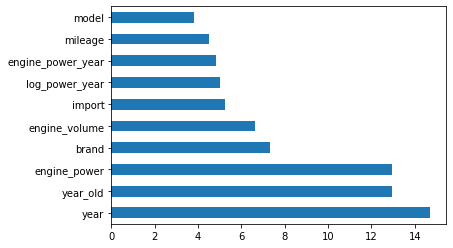

In [92]:
(pd.Series(model.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

### Model 3 : GradientBoostingRegressor

In [93]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000)

In [94]:
GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000)

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000)

In [95]:
predict_test = np.exp(gb.predict(X_test))
predict_submission_3 = np.exp(gb.predict(X_sub))

In [96]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.84%


kaggle 27,67369

In [97]:
sample_submission['price'] = predict_submission_3*0.80
sample_submission.to_csv(f'./input/submission_2_v_GradientBoosting.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.004662e+05
1,1100549428,8.997885e+05
2,1100658222,8.789398e+05
3,1100937408,6.489448e+05
4,1101037972,6.968437e+05
5,1100912634,9.299075e+05
6,1101228730,5.647322e+05
7,1100165896,4.517362e+05
8,1100768262,2.459456e+06
9,1101218501,7.988075e+05


<AxesSubplot:>

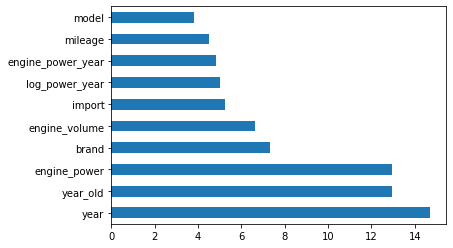

In [98]:
(pd.Series(model.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

### Model 4 : RandomForestRegressor

In [122]:
rfr = RandomForestRegressor(n_estimators=1000,
                            max_depth = 15,
                            max_features = 'log2',
                            random_state = 42,
                            oob_score=True,) 
rfr.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=1000,
                      oob_score=True, random_state=42)

In [123]:
predict_test = np.exp(rfr.predict(X_test)) 
predict_submission_4 = np.exp(rfr.predict(X_sub))

In [124]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 17.16%


kaggle 23,91505

In [125]:
sample_submission['price'] = predict_submission_4*0.80
sample_submission.to_csv(f'./input/submission_2_v_RandomForest.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.216171e+05
1,1100549428,8.769354e+05
2,1100658222,8.306570e+05
3,1100937408,6.164045e+05
4,1101037972,6.923411e+05
5,1100912634,9.191808e+05
6,1101228730,6.169478e+05
7,1100165896,4.711541e+05
8,1100768262,1.800449e+06
9,1101218501,7.288562e+05


<AxesSubplot:>

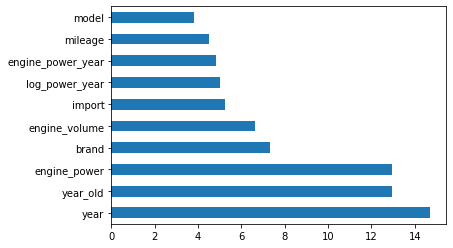

In [103]:
(pd.Series(model.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

### Staking

In [104]:
best_lr = Ridge(alpha=0.5, 
                max_iter=100, 
                random_state=RANDOM_SEED)

bagger_lr = BaggingRegressor(base_estimator=best_lr, 
                             random_state=RANDOM_SEED, 
                             n_estimators=20)

knr = KNeighborsRegressor(n_neighbors=3)

best_rf = RandomForestRegressor(n_estimators=200,
                                n_jobs=-1, 
                                random_state=RANDOM_SEED,
                                verbose=False)

best_xgb = xgb.XGBRegressor(verbosity=1, 
                            random_state=RANDOM_SEED,
                            learning_rate=0.3,
                            n_estimators=100,
                            max_depth=6)

best_cat = CatBoostRegressor(logging_level = 'Silent', 
                             task_type="CPU", 
                             random_seed=RANDOM_SEED,
                             iterations = 2000,
                             depth = 8)
best_tree = DecisionTreeRegressor(max_depth=20, 
                                  max_features='auto', 
                                  min_samples_split=50,
                                  random_state=RANDOM_SEED)

best_bag_tree = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=50,
                                                      random_state=RANDOM_SEED),
                                                      max_features=0.75, 
                                                      n_estimators=100)

In [105]:
estimators = [('Ridge', best_lr),
              ('Bag_lr', bagger_lr),
              ('knr', knr),
              ('Random Forest', best_rf),
              ('XGB', best_xgb),
              ('CatBoost', best_cat),
              ('best_tree', best_tree),
              ('best_bag_tree', best_bag_tree)
             ]
estimators_champions = [
              ('Bag_lr', bagger_lr),
              ('Random Forest', best_rf),
              ('CatBoost', best_cat),
             ]
final_estimators = [('Ridge', Ridge(random_state=RANDOM_SEED)),
                    ('Random Forest', RandomForestRegressor(random_state=RANDOM_SEED)),
                    ('XGB', xgb.XGBRegressor(random_state=RANDOM_SEED)),
                    ('Catboost', CatBoostRegressor(random_state=RANDOM_SEED)),
                   ]

In [106]:
stacks_1_layer = [(est[0], StackingRegressor(estimators = estimators, 
                                             final_estimator=est[1], 
                                             verbose = False)) 
                  for est in final_estimators]

In [108]:
predicts = []
for stack in stacks_1_layer:
    print(type(stack[1]))
    stack[1].fit(X_train, y_train)
    y_pred = stack[1].predict(X_test)
    mape(y_test, y_pred)
#     predicts.append((stack[0], y_pred))

<class 'sklearn.ensemble._stacking.StackingRegressor'>
<class 'sklearn.ensemble._stacking.StackingRegressor'>
<class 'sklearn.ensemble._stacking.StackingRegressor'>
<class 'sklearn.ensemble._stacking.StackingRegressor'>
Learning rate set to 0.114492
0:	learn: 1378659.0490596	total: 64.1ms	remaining: 1m 4s
1:	learn: 1270274.0395477	total: 102ms	remaining: 50.8s
2:	learn: 1177892.0127195	total: 138ms	remaining: 46s
3:	learn: 1099549.5972057	total: 173ms	remaining: 43.1s
4:	learn: 1032217.1454289	total: 208ms	remaining: 41.5s
5:	learn: 975422.9729056	total: 243ms	remaining: 40.2s
6:	learn: 928093.7741623	total: 277ms	remaining: 39.3s
7:	learn: 888797.5812040	total: 312ms	remaining: 38.7s
8:	learn: 855702.0588798	total: 346ms	remaining: 38.1s
9:	learn: 828633.5151129	total: 380ms	remaining: 37.6s
10:	learn: 806144.2633709	total: 416ms	remaining: 37.4s
11:	learn: 787198.7703070	total: 450ms	remaining: 37s
12:	learn: 772175.2267468	total: 484ms	remaining: 36.8s
13:	learn: 759665.9110235	tota

144:	learn: 680388.3574934	total: 5.12s	remaining: 30.2s
145:	learn: 680280.3402137	total: 5.16s	remaining: 30.2s
146:	learn: 680182.2725897	total: 5.2s	remaining: 30.2s
147:	learn: 680166.8590460	total: 5.23s	remaining: 30.1s
148:	learn: 680138.5058314	total: 5.27s	remaining: 30.1s
149:	learn: 680109.6758803	total: 5.3s	remaining: 30.1s
150:	learn: 680013.7734695	total: 5.34s	remaining: 30s
151:	learn: 679934.4934810	total: 5.37s	remaining: 30s
152:	learn: 679907.7030407	total: 5.41s	remaining: 29.9s
153:	learn: 679882.0402748	total: 5.44s	remaining: 29.9s
154:	learn: 679845.1524107	total: 5.48s	remaining: 29.9s
155:	learn: 679752.7644107	total: 5.51s	remaining: 29.8s
156:	learn: 679642.6923253	total: 5.54s	remaining: 29.8s
157:	learn: 679618.9074597	total: 5.58s	remaining: 29.7s
158:	learn: 679568.8283166	total: 5.61s	remaining: 29.7s
159:	learn: 679483.8304315	total: 5.64s	remaining: 29.6s
160:	learn: 679460.2511547	total: 5.68s	remaining: 29.6s
161:	learn: 679403.8488250	total: 5.7

289:	learn: 673859.6057180	total: 10.3s	remaining: 25.1s
290:	learn: 673841.5114764	total: 10.3s	remaining: 25.1s
291:	learn: 673810.6188867	total: 10.3s	remaining: 25s
292:	learn: 673741.1578217	total: 10.4s	remaining: 25s
293:	learn: 673733.2211173	total: 10.4s	remaining: 25s
294:	learn: 673708.6323999	total: 10.4s	remaining: 24.9s
295:	learn: 673702.8371778	total: 10.5s	remaining: 24.9s
296:	learn: 673519.3003421	total: 10.5s	remaining: 24.8s
297:	learn: 673459.2264381	total: 10.5s	remaining: 24.8s
298:	learn: 673437.2644766	total: 10.6s	remaining: 24.8s
299:	learn: 673414.1140561	total: 10.6s	remaining: 24.7s
300:	learn: 673406.7305629	total: 10.6s	remaining: 24.7s
301:	learn: 673401.1603082	total: 10.7s	remaining: 24.6s
302:	learn: 673380.7801023	total: 10.7s	remaining: 24.6s
303:	learn: 673343.0673293	total: 10.7s	remaining: 24.6s
304:	learn: 673336.2060665	total: 10.8s	remaining: 24.5s
305:	learn: 673302.4763571	total: 10.8s	remaining: 24.5s
306:	learn: 673292.6796921	total: 10.

436:	learn: 669875.6765915	total: 15.4s	remaining: 19.8s
437:	learn: 669769.1319982	total: 15.4s	remaining: 19.8s
438:	learn: 669767.0373552	total: 15.4s	remaining: 19.7s
439:	learn: 669756.2548385	total: 15.5s	remaining: 19.7s
440:	learn: 669744.2370369	total: 15.5s	remaining: 19.7s
441:	learn: 669737.4382076	total: 15.5s	remaining: 19.6s
442:	learn: 669701.4244061	total: 15.6s	remaining: 19.6s
443:	learn: 669674.4048778	total: 15.6s	remaining: 19.5s
444:	learn: 669660.9425280	total: 15.6s	remaining: 19.5s
445:	learn: 669616.3664556	total: 15.7s	remaining: 19.5s
446:	learn: 669592.3001975	total: 15.7s	remaining: 19.4s
447:	learn: 669530.6774242	total: 15.7s	remaining: 19.4s
448:	learn: 669522.1812610	total: 15.8s	remaining: 19.3s
449:	learn: 669497.0855474	total: 15.8s	remaining: 19.3s
450:	learn: 669489.7204081	total: 15.8s	remaining: 19.3s
451:	learn: 669478.6619553	total: 15.9s	remaining: 19.2s
452:	learn: 669462.8626337	total: 15.9s	remaining: 19.2s
453:	learn: 669437.2230073	tota

582:	learn: 667667.4979983	total: 20.5s	remaining: 14.7s
583:	learn: 667661.7437819	total: 20.5s	remaining: 14.6s
584:	learn: 667655.5631068	total: 20.6s	remaining: 14.6s
585:	learn: 667642.6193037	total: 20.6s	remaining: 14.5s
586:	learn: 667628.3693081	total: 20.6s	remaining: 14.5s
587:	learn: 667611.4368730	total: 20.7s	remaining: 14.5s
588:	learn: 667599.4056755	total: 20.7s	remaining: 14.4s
589:	learn: 667593.5577635	total: 20.7s	remaining: 14.4s
590:	learn: 667589.4870246	total: 20.8s	remaining: 14.4s
591:	learn: 667569.7042102	total: 20.8s	remaining: 14.3s
592:	learn: 667549.7353423	total: 20.8s	remaining: 14.3s
593:	learn: 667548.7364858	total: 20.9s	remaining: 14.3s
594:	learn: 667539.0752477	total: 20.9s	remaining: 14.2s
595:	learn: 667490.7458832	total: 20.9s	remaining: 14.2s
596:	learn: 667486.4724883	total: 21s	remaining: 14.2s
597:	learn: 667483.7486066	total: 21s	remaining: 14.1s
598:	learn: 667471.9060208	total: 21s	remaining: 14.1s
599:	learn: 667455.7645377	total: 21.

729:	learn: 666072.5285457	total: 25.7s	remaining: 9.49s
730:	learn: 666038.3255023	total: 25.7s	remaining: 9.46s
731:	learn: 666022.7176414	total: 25.7s	remaining: 9.42s
732:	learn: 666020.9898838	total: 25.8s	remaining: 9.39s
733:	learn: 666011.7826127	total: 25.8s	remaining: 9.35s
734:	learn: 666002.8846277	total: 25.8s	remaining: 9.32s
735:	learn: 665996.5169443	total: 25.9s	remaining: 9.28s
736:	learn: 665993.3938785	total: 25.9s	remaining: 9.25s
737:	learn: 665991.5550739	total: 26s	remaining: 9.21s
738:	learn: 665987.1488992	total: 26s	remaining: 9.18s
739:	learn: 665981.0893041	total: 26s	remaining: 9.14s
740:	learn: 665979.0862907	total: 26.1s	remaining: 9.11s
741:	learn: 665974.9306147	total: 26.1s	remaining: 9.07s
742:	learn: 665972.2219318	total: 26.1s	remaining: 9.04s
743:	learn: 665968.5787600	total: 26.2s	remaining: 9.01s
744:	learn: 665953.1399904	total: 26.2s	remaining: 8.97s
745:	learn: 665948.0574274	total: 26.2s	remaining: 8.94s
746:	learn: 665944.8160385	total: 26.

878:	learn: 665100.8216572	total: 30.9s	remaining: 4.26s
879:	learn: 665096.6902652	total: 31s	remaining: 4.22s
880:	learn: 665095.5273593	total: 31s	remaining: 4.19s
881:	learn: 665092.2449755	total: 31.1s	remaining: 4.15s
882:	learn: 665090.7824788	total: 31.1s	remaining: 4.12s
883:	learn: 665088.4190418	total: 31.1s	remaining: 4.08s
884:	learn: 665079.4889757	total: 31.2s	remaining: 4.05s
885:	learn: 665077.7501642	total: 31.2s	remaining: 4.01s
886:	learn: 665074.8680351	total: 31.2s	remaining: 3.98s
887:	learn: 665072.7417953	total: 31.3s	remaining: 3.94s
888:	learn: 665070.9712466	total: 31.3s	remaining: 3.91s
889:	learn: 665069.5963507	total: 31.3s	remaining: 3.87s
890:	learn: 665045.6398975	total: 31.4s	remaining: 3.84s
891:	learn: 665022.9757030	total: 31.4s	remaining: 3.8s
892:	learn: 664996.8063933	total: 31.4s	remaining: 3.77s
893:	learn: 664990.1224873	total: 31.5s	remaining: 3.73s
894:	learn: 664975.0630068	total: 31.5s	remaining: 3.7s
895:	learn: 664969.2207972	total: 31.

In [109]:
best_stack = StackingRegressor(estimators = estimators, 
                              final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)

In [112]:
final_estimator=Ridge(random_state=RANDOM_SEED)
best_stack.fit(X, y)

C:\Users\allkotraz\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.62188e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\allkotraz\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.55677e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\allkotraz\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.55884e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\allkotraz\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.69797e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\allkotraz\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.69171e-17): result

NameError: name 'make_submission' is not defined

In [121]:
predict_test = np.exp(best_stack.predict(X_test)) 
predict_submission_4 = best_stack.predict(X_sub)
sample_submission['price'] = predict_submission_4*0.91
sample_submission.to_csv(f'./input/stacking_correction.csv', index=False)
sample_submission.head(10)

<ipython-input-121-4b8fe8ed93b4>:1: RuntimeWarning: overflow encountered in exp
  predict_test = np.exp(best_stack.predict(X_test))


,sell_id,price
0,1100575026,7.946978e+05
1,1100549428,1.058584e+06
2,1100658222,1.263091e+06
3,1100937408,6.267875e+05
4,1101037972,9.395260e+05
5,1100912634,1.040641e+06
6,1101228730,8.312494e+05
7,1100165896,4.489443e+05
8,1100768262,2.230972e+06
9,1101218501,1.030410e+06
